## By tr

1.  <span style="color:red"> **txid** - id транзакции </span>
2.  **version** - ???
3.  **locktime** - ???
4.  **vin** - отправители <br>
Список содержит в себе столько элементов, сколько было адресов-отправителей. Для каждого:<br>
<span style="color:red">4.1 **txid** </span> - id транзакции, в которой данный адрес получил биткоины<br> 
<span style="color:red">4.2 **vout** - число получателей </span><br> 
4.3 **sequence** ??? одинаковое значение для всех адресов в vout<br>
4.4 n - ???<br> 
4.5 **scriptSig** {'hex' - signature and public key **of the input address** in hex format, 'asm' - signature and public key in asm format} https://bitcoin.stackexchange.com/questions/24651/whats-asm-in-transaction-inputs-scriptsig <br>
<span style="color:red">4.6 **addr** - адрес кошелька отправителя</span><br>
4.7 **valueSat** - $value * 10^{8}$<br>
<span style="color:red">4.8 **value** - величина перевода в биткоинах</span><br>
<span style="color:red">4.9 **doubleSpentTxID** ???</span> <br>
5.  **vout** - получатели <br>
5.1 <span style="color:red">**value** - полученная сумма в биткоинах</span><br>
5.2 n<br>
5.3 **scriptPubKey** {'hex' - signature and public key in hex format, 'asm' - signature and public key in asm format, <span style="color:red"> 'addresses' - адрес получателя</span>, 'type'} <br>
5.4 <span style="color:red">**spentTxId** - транзакция, в которой полученные биткоины были потрачены </span><br>
5.5 **spentIndex** - ???<br>
5.6 **spentHeight** - номер блока, в который попала транзакция, по которой были потраченые полученные биткоины<br>
6.  **blockhash** - хэш блока (в одном блоке может быть много несвязанных между собой транзакций)
7.  **blockheight** - номер блока в цепи
8.  **confirmations** - кол-во подтверждений блока (чем больше, чем старее и надежнее транзакция)
9.  <span style="color:red">**time** - время совершения операции (обычно совпадает с временем создания блока)</span>
10. **blocktime** - время создания блока
11. **valueOut** - общий размер полученных средств (общая сумма отправленным минус комиссия)
12. **size** - размер тразнакции (в байтах) (блок обычно содержит в себе около 1 Мб транзакций)
13. **valueIn** - общий размер отправленных средств
14. **fees** - комиссия

In [190]:
import time
import json
import numpy as np
import pandas as pd
import requests
import networkx as nx

from statistics import mean 
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

## lists of suspicious transactions and addresses

In [191]:
tr_list = ['c7a3673f869fc9c5c5e8f032af97546efed0435762e4ef728f99b6725c027f9b',
           '34ed08b17fff9cbe51ce33c62c6c1bb115f82aeec60997bfb216126bf747b5c8']

In [192]:
addr_list = ['3AuShAzkBaAvL6Xc4y61Jfnf7AM7s3Wpmb',
             '1JqmxxswaEpvEcLJJLe8BTvmSHKYzY7LBn', 
             '3HjJQWMhhJjAkPiZKywDYyhXDdWkSFLW9F', 
             '1KqtK7K46kiFCV2XzAt43AYxNVwPuEccW6',
             '1HRPPH6gVPhL4tTbAM5CCcDFt2bXpR5vNm',
             '1JqmxxswaEpvEcLJJLe8BTvmSHKYzY7LBn',
             '3BPMdL5WVNYdBWVzfqRNkAMHiMkegporXn',
             '3MycntSknbumLyRX56X8xbwxJ1zqHHq1VD',
             '3HpWfb94RXgbj59PnJijayj9t2ebFkfCQn',
             '3GdH7YrcFgQv4EANKDw66aZwruYCQ21LpL',
             #'1FQFFxz5TPJsRwkqHJa4ecd9gjQS2hYcbt',
             '3HjJQWMhhJjAkPiZKywDYyhXDdWkSFLW9F',
             '1KqtK7K46kiFCV2XzAt43AYxNVwPuEccW6']

## read json

In [193]:
%%time
with open('tx_json.json', 'r') as f:
    results = json.load(f)

CPU times: user 28.2 ms, sys: 28.8 ms, total: 57 ms
Wall time: 57.5 ms


In [194]:
df = []
trs = list(results.keys())
for tr in trs:
    df.append(results[tr])
    
cols = list(results[trs[0]].keys())
data = pd.DataFrame(df, columns=cols)

In [195]:
data.shape

(351, 32)

In [196]:
data['is_coinbase'] = data['is_coinbase'].map({False: 0, True: 1}).astype(int)
data['is_double_spend'] = data['is_double_spend'].map({False: 0, True: 1}).astype(int)
data['is_sw_tx'] = data['is_sw_tx'].map({False: 0, True: 1}).astype(int)

In [197]:
#add suspicious labels
data['is_suspicious'] = data['txid'].apply(lambda x: 1 if x in tr_list else 0)

## K-Means on transactions

In [212]:
scaler = MinMaxScaler(feature_range=(0,1))

drop_cols =  ['txid', 'confirmations', 'time', 'list_of_inp_adds', 'list_of_outp_adds',
              'max_prev_time', 'min_prev_time', 'avg_prev_time', 
              'max_next_time', 'min_next_time', 'avg_next_time', 'is_coinbase', 'is_double_spend',
              'is_suspicious']

feats = [item for item in list(data.columns) if item not in drop_cols]

ids  = data['txid']
susp_labels = data['is_suspicious']
train_txs = data[feats]

train_txs_sc = scaler.fit_transform(train_txs)
train_txs_sc = pd.DataFrame(train_txs_sc, columns=feats)
train_txs_sc = train_txs_sc.dropna()

In [213]:
#проводим кластеризацию методом K-means
kmeans = KMeans(n_clusters=4, random_state=17)
kmeans.fit(train_txs_sc);

train_txs_sc['kmeans'] = kmeans.labels_
means_txs = train_txs_sc.groupby(['kmeans']).mean()

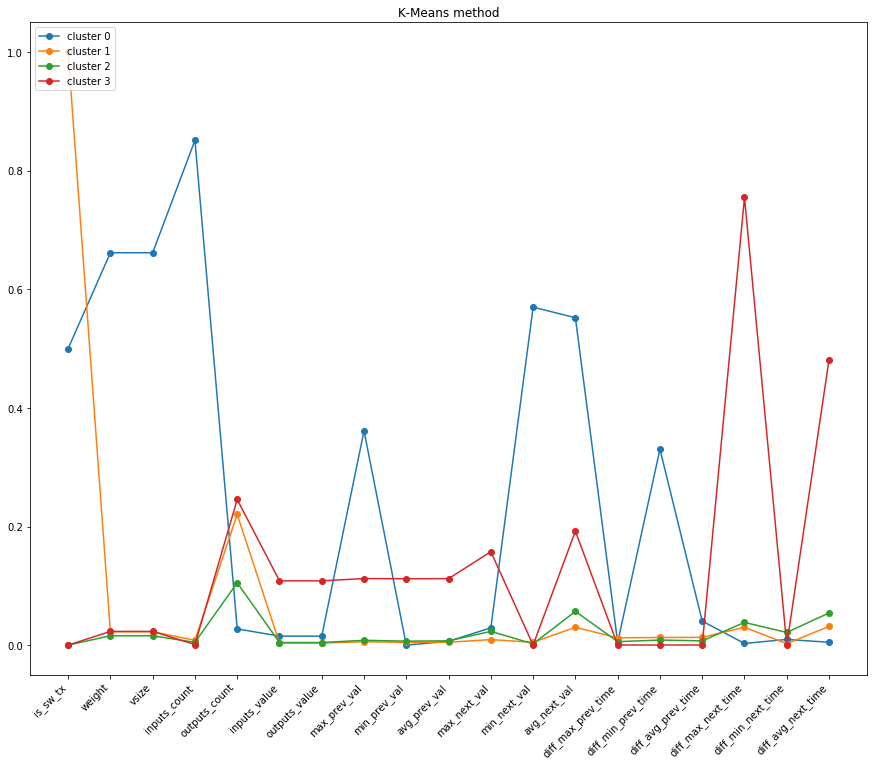

In [214]:
plt.figure(figsize=(15,12)) #формируем область для построения графиков под каждый из методов
for n in range(means_txs.shape[0]): #для каждого кластера из данного метода
    plt.plot(feats, means_txs.iloc[n, :].values, marker='o', label='cluster {}'.format(n))
    
plt.legend(loc = 'upper left') #делаем легенду графиа
plt.title('K-Means method') #название графика
plt.xticks(rotation=45, ha="right");

In [215]:
train_txs_sc['txid'] = ids
train_txs_sc['is_suspicious'] = susp_labels

In [216]:
train_txs_sc.head()

,is_sw_tx,weight,vsize,inputs_count,outputs_count,inputs_value,outputs_value,max_prev_val,min_prev_val,avg_prev_val,...,avg_next_val,diff_max_prev_time,diff_min_prev_time,diff_avg_prev_time,diff_max_next_time,diff_min_next_time,diff_avg_next_time,kmeans,txid,is_suspicious
0,1.0,0.622793,0.622784,1.0,0.095890,0.001608,0.001607,0.019526,0.000003,0.003322,...,0.095553,0.001262,1.000000,0.105111,0.010450,0.000468,0.011391,0,c7a3673f869fc9c5c5e8f032af97546efed0435762e4ef...,1
1,0.0,1.000000,1.000000,1.0,0.000000,0.000877,0.000849,0.996161,0.000003,0.012414,...,0.905205,0.000942,0.302465,0.040271,0.000864,0.034844,0.007438,0,34ed08b17fff9cbe51ce33c62c6c1bb115f82aeec60997...,1
2,1.0,0.023650,0.023642,0.0,0.301370,0.012338,0.012338,0.012454,0.012460,0.012455,...,0.036632,0.000397,0.000367,0.000397,0.005940,0.000000,0.007665,1,3fd8257abd01c2348d3a3ff0c97b774533da5ec177970d...,0
3,1.0,0.043717,0.043718,0.0,0.561644,0.002259,0.002259,0.002880,0.002886,0.002881,...,0.014440,0.000045,0.000042,0.000045,0.061430,0.001047,0.032096,1,43cbe088eeade4fdec266efc7fd5bf03c525edf11d69c7...,0
4,1.0,0.024632,0.024633,0.0,0.315068,0.000162,0.000162,0.000312,0.000318,0.000313,...,0.019948,0.000000,0.000000,0.000000,0.072639,0.001035,0.048313,1,c4f7e9296fe219bb4a43673a9fcf2d4b433cabd097afde...,0


In [19]:
#сравнение кластеров и лейблов is_suspicious

## K-Means on addresses

1. написать второй вариант выгрузки транзакций - по адресам
2. написать преобразование датафрейма "строка - транзакция" в "строка - транзакция для одного адреса"

In [45]:
data.head(2)

,txid,confirmations,time,is_coinbase,is_double_spend,is_sw_tx,weight,vsize,inputs_count,outputs_count,...,min_next_val,avg_next_val,list_of_outp_adds,diff_max_prev_time,diff_min_prev_time,diff_avg_prev_time,diff_max_next_time,diff_min_next_time,diff_avg_next_time,is_suspicious
0,c7a3673f869fc9c5c5e8f032af97546efed0435762e4ef...,11027,1551702368,0,0,1,75980,18995,206,8,...,665478,1569184476,[{'prev_address': '1HRPPH6gVPhL4tTbAM5CCcDFt2b...,4130,3540827,343932,593812,697,78521,1
1,34ed08b17fff9cbe51ce33c62c6c1bb115f82aeec60997...,100836,1500051501,0,0,0,121676,30419,206,1,...,14819134841,14819134841,[{'prev_address': '1KqtK7K46kiFCV2XzAt43AYxNVw...,3081,1070977,131769,51895,51895,51895,1


Будем рассматривать 4 вида транзакций (и по-разному формировать для них матрицу фичей)

|transaction_type|num_of_inputs  |num_of_outputs|
|----|---------------|--------------|
| 1  | 1             | 1            |
| 2  | several       | 1            |
| 3  | 1             | several      |
| 4  | several       | several      |

In [46]:
def transaction_type(row):
    if   row[0]==1 and row[1]==1: return 1
    elif row[0] >1 and row[1]==1: return 2
    elif row[0]==1 and row[1] >1: return 3
    elif row[0] >1 and row[1] >1: return 4
    else: return 0

In [47]:
data['transaction_type'] = [transaction_type(x) for x in data[['inputs_count', 'outputs_count']].values]

In [51]:
#кол-во транзакций каждого типа в датасете
data.groupby('transaction_type').count()[['txid']].T

transaction_type,1,2,3,4
txid,4,4,277,66


## Feature Matrix

Хотим получить матрицу, где по строкам будут транзакции относительно адресов:
1. если у транзакции было n входящих (исходящих) адресов, то данная транзакция преобразовывается в n строк
2. если у транзакции было n входящих и m исходящих адресов, то данная транзакция преобразовывается в n+m строк

#### Features

1. 'txid' - id текущей транзакции
2. 'confirmations' - число подтверждений 
3. 'time' - время совершения данной транзакции 
4. 'is_coinbase' - флаг 
5. 'is_double_spend' - флаг
6. 'is_sw_tx' - флаг 
7. 'weight' - вес
8. 'vsize' - вес
9. 'inputs_count' - число входящих адресов
10. 'outputs_count'- число исходящих адресов
11. 'inputs_value' - общая сумма текущей транзакции (отличается от curr_value, если более 1 входа)
12. 'outputs_value' - общая сумма исходящей транзакции (отличается от curr_value-fee, если более 1 выхода) 
13. 'max_prev_val' - максимальная сумма среди предыдущих транзакций (отличается от tot_prev_tx_value, если более 1 входа) 
14. 'min_prev_val' - минимальная сумма среди предыдущих транзакций (отличается от tot_prev_tx_value, если более 1 входа)   
15. 'avg_prev_val' - средняя сумма предыдущих транзакций (отличается от tot_prev_tx_value, если более 1 входа)          
16. 'max_next_val' - максимальная сумма среди следующих транзакций (отличается от tot_next_tx_value, если более 1 входа)
17. 'min_next_val' - минимальная сумма среди следующих транзакций (отличается от tot_next_tx_value, если более 1 входа)
18. 'avg_next_val' - средняя сумма следующих транзакций (отличается от tot_next_tx_value, если более 1 входа)          
19. 'diff_max_prev_time' - максимальная разница во времени текущей транзакции относительно всех предыдущих (отличается от diff_prev_time, если более 1 входа)
20. 'diff_min_prev_time' - минимальна разница во времени текущей транзакции относительно всех предыдущих (отличается от diff_prev_time, если более 1 входа)
21. 'diff_avg_prev_time' - средняя разница во времени текущей транзакции относительно всех предыдущих (отличается от diff_prev_time, если более 1 входа)
22. 'diff_max_next_time' - максимальная разница во времени текущей транзакции относительно всех следующих (отличается от diff_next_time, если более 1 входа)
23. 'diff_min_next_time' - минимальная разница во времени текущей транзакции относительно всех следующих (отличается от diff_next_time, если более 1 входа)
24. 'diff_avg_next_time' - средняя разница во времени текущей транзакции относительно всех следующих (отличается от diff_next_time, если более 1 входа)
25. 'is_suspicious' - флаг, является ли транзакция подозрительной (1, если транзакция есть в первоначальном списке tr_list)
26. 'transaction_type' - тип пранзакции (1,2,3,4)
27. 'input_add' - входящий адрес
28. 'output_add' - исходящий адрес
29. 'curr_value' - сумма транзакции для данного входящего/исходящего адреса (в зависимости от transaction_type)
30. 'tot_prev_tx_value' - размер предыдущей транзакции для данного input_add (если transaction_type=4, то берется avg_prev_val) <span style="color:red"> (лучше брать avg, min или max ??????)</span>
31. 'tot_next_tx_value' - размер следующей транзакции для данного input_add (если transaction_type=4, то берется avg_next_val) <span style="color:red"> (лучше брать avg, min или max ??????)</span>
32. 'diff_prev_time' - задержка текущей транзакции относительно предыдущей (если transaction_type=4, то берется diff_avg_prev_time)  <span style="color:red"> (лучше брать avg, min или max ??????)</span>
33. diff_next_time - задержка следующей транзакции относительно текущей (если transaction_type=4, то берется diff_avg_next_time)  <span style="color:red"> (лучше брать avg, min или max ??????)</span>

In [52]:
cols = ['txid',
 'confirmations',
 'time',
 'is_coinbase',
 'is_double_spend',
 'is_sw_tx',
 'weight',
 'vsize',
 'inputs_count',
 'outputs_count',
 'inputs_value',
 'outputs_value',
 'max_prev_val',
 'min_prev_val',
 'avg_prev_val',
 'max_next_val',
 'min_next_val',
 'avg_next_val',
 'diff_max_prev_time',
 'diff_min_prev_time',
 'diff_avg_prev_time',
 'diff_max_next_time',
 'diff_min_next_time',
 'diff_avg_next_time',
 'is_suspicious',
 'transaction_type',
 'input_add',
 'output_add',
 'curr_value',
 'tot_prev_tx_value',
 'tot_next_tx_value',
 'diff_prev_time',
 'diff_next_time']

## transaction_type = 1

In [53]:
data_1 = data[data['transaction_type'] == 1]

#входящий и исходящий адреса
data_1['input_add'] = data_1['list_of_inp_adds'].apply(lambda x: x[0]['prev_address'])
data_1['output_add'] = data_1['list_of_outp_adds'].apply(lambda x: x[0]['prev_address'])

#сумма текущей транзакции
#считаем current value по input'у
data_1['curr_value'] = data_1['list_of_inp_adds'].apply(lambda x: x[0]['curr_value'])

#общая сумма предыдущей и следующей транзакций (не сколько на адрес пришло, а именно всей транзакции целиком)
data_1['tot_prev_tx_value'] = data_1['list_of_inp_adds'].apply(lambda x: x[0]['total_prev_val'])
data_1['tot_next_tx_value'] = data_1['list_of_outp_adds'].apply(lambda x: x[0]['total_next_val'])

#дата совершения предыдущей и следующей транзакций 
data_1['prev_time'] = data_1['list_of_inp_adds'].apply(lambda x: x[0]['prev_time'])
data_1['next_time'] = data_1['list_of_outp_adds'].apply(lambda x: x[0]['next_time'])

#задержка относительно предыдущей и следующей транзакций 
data_1['diff_prev_time'] = data_1['time'] - data_1['prev_time']
data_1['diff_next_time'] = data_1['next_time'] - data_1['time']


data_1_upd = data_1[cols]

In [54]:
len(data_1_upd.columns)

33

## transaction_type = 2

In [55]:
data_2 = data[data['transaction_type'] == 2].reset_index(drop=True)


#convert input adds
tmp_inp = data_2.list_of_inp_adds\
          .apply(pd.Series).merge(data_2[['txid','list_of_inp_adds']], left_index = True, right_index = True)\
          .drop(['list_of_inp_adds'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'input_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

tmp_inp = tmp_inp['input_add'].apply(pd.Series)\
          .merge(tmp_inp[['txid','input_add']], left_index = True, right_index = True)\
          .drop(['input_add'], axis = 1)\
          .rename({'prev_address': 'input_add','total_prev_val': 'tot_prev_tx_value'}, axis=1)


#вытаскиваем исходящий адрес
data_2['output_add'] = data_2['list_of_outp_adds'].apply(lambda x: x[0]['prev_address'])
#вытаскиваем общую сумму следующей транзакции 
data_2['tot_next_tx_value'] = data_2['list_of_outp_adds'].apply(lambda x: x[0]['total_next_val'])
#дата совершения следующей транзакции
data_2['next_time'] = data_2['list_of_outp_adds'].apply(lambda x: x[0]['next_time'])

data_2 = data_2.set_index('txid')
tmp_inp = tmp_inp.set_index('txid')


cols_to_take = ['output_add', 'tot_next_tx_value', 'next_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

data_2_upd = tmp_inp.join(data_2[cols_to_take], how='left').reset_index()

In [56]:
#задержка относительно предыдущей и следующей транзакций 
data_2_upd['diff_prev_time'] = data_2_upd['time'] - data_2_upd['prev_time']
data_2_upd['diff_next_time'] = data_2_upd['next_time'] - data_2_upd['time']

In [57]:
data_2_upd = data_2_upd[cols]

In [58]:
len(data_2_upd.columns)

33

## transaction_type = 3

In [60]:
data_3 = data[data['transaction_type'] == 3].reset_index(drop=True)

#convert input adds
tmp_outp = data_3.list_of_outp_adds\
          .apply(pd.Series).merge(data_3[['txid','list_of_outp_adds']], left_index = True, right_index = True)\
          .drop(['list_of_outp_adds'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'output_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

tmp_outp = tmp_outp['output_add'].apply(pd.Series)\
          .merge(tmp_outp[['txid','output_add']], left_index = True, right_index = True)\
          .drop(['output_add'], axis = 1)\
          .rename({'prev_address': 'output_add','total_next_val': 'tot_next_tx_value'}, axis=1)

#вытаскиваем исходящий адрес
data_3['input_add'] = data_3['list_of_inp_adds'].apply(lambda x: x[0]['prev_address'])
#вытаскиваем общую сумму следующей транзакции 
data_3['tot_prev_tx_value'] = data_3['list_of_inp_adds'].apply(lambda x: x[0]['total_prev_val'])
#дата совершения следующей транзакции
data_3['prev_time'] = data_3['list_of_inp_adds'].apply(lambda x: x[0]['prev_time'])

data_3 = data_3.set_index('txid')
tmp_outp = tmp_outp.set_index('txid')


cols_to_take = ['input_add', 'tot_prev_tx_value', 'prev_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

data_3_upd = tmp_outp.join(data_3[cols_to_take], how='left').reset_index()

In [62]:
#задержка относительно предыдущей и следующей транзакций 
data_3_upd['diff_prev_time'] = data_3_upd['time'] - data_3_upd['prev_time']
data_3_upd['diff_next_time'] = data_3_upd['next_time'] - data_3_upd['time']

In [63]:
data_3_upd = data_3_upd[cols]

## transaction_type = 4

In [64]:
data_4 = data[data['transaction_type'] == 4].reset_index(drop=True)

In [65]:
#convert input adds
tmp_inp = data_4.list_of_inp_adds\
          .apply(pd.Series).merge(data_4[['txid','list_of_inp_adds']], left_index = True, right_index = True)\
          .drop(['list_of_inp_adds'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'input_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

tmp_inp = tmp_inp['input_add'].apply(pd.Series)\
          .merge(tmp_inp[['txid','input_add']], left_index = True, right_index = True)\
          .drop(['input_add'], axis = 1)\
          .rename({'prev_address': 'input_add','total_prev_val': 'tot_prev_tx_value'}, axis=1)

tmp_inp['output_add'] = tmp_inp['txid']

In [66]:
#convert input adds
tmp_outp = data_4.list_of_outp_adds\
          .apply(pd.Series).merge(data_4[['txid','list_of_outp_adds']], left_index = True, right_index = True)\
          .drop(['list_of_outp_adds'], axis = 1)\
          .melt(id_vars = ['txid'], value_name = 'output_add')\
          .drop('variable', axis = 1).dropna().reset_index(drop=True)

tmp_outp = tmp_outp['output_add'].apply(pd.Series)\
          .merge(tmp_outp[['txid','output_add']], left_index = True, right_index = True)\
          .drop(['output_add'], axis = 1)\
          .rename({'prev_address': 'output_add','total_next_val': 'tot_next_tx_value'}, axis=1)

tmp_outp['input_add'] = tmp_outp['txid']

In [67]:
data_4['tot_next_tx_value'] = data_4['avg_next_val']
data_4['tot_prev_tx_value'] = data_4['avg_prev_val']

In [68]:
data_4['next_time'] = data_4['avg_next_time']
data_4['prev_time'] = data_4['avg_prev_time']

In [69]:
data_4 = data_4.set_index('txid')
tmp_inp = tmp_inp.set_index('txid')
tmp_outp = tmp_outp.set_index('txid')

In [70]:
cols_to_take_1 = ['tot_next_tx_value', 'next_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

cols_to_take_2 = ['tot_prev_tx_value', 'prev_time', 'confirmations',
                'time', 'is_coinbase', 'is_double_spend', 'is_sw_tx', 'weight', 'vsize',
                'inputs_count', 'outputs_count', 'inputs_value', 'outputs_value', 'max_prev_val',
                'min_prev_val', 'avg_prev_val', 'max_next_val', 'min_next_val', 'avg_next_val',
                'diff_max_prev_time', 'diff_min_prev_time', 'diff_avg_prev_time', 'diff_max_next_time',
                'diff_min_next_time', 'diff_avg_next_time', 'is_suspicious', 'transaction_type']

In [71]:
data_4_upd_1 = tmp_inp.join(data_4[cols_to_take_1], how='left').reset_index()
data_4_upd_2 = tmp_outp.join(data_4[cols_to_take_2], how='left').reset_index()

In [72]:
#задержка относительно предыдущей и следующей транзакций 
data_4_upd_1['diff_prev_time'] = data_4_upd_1['time'] - data_4_upd_1['prev_time']
data_4_upd_1['diff_next_time'] = data_4_upd_1['next_time'] - data_4_upd_1['time']

#задержка относительно предыдущей и следующей транзакций 
data_4_upd_2['diff_prev_time'] = data_4_upd_2['time'] - data_4_upd_2['prev_time']
data_4_upd_2['diff_next_time'] = data_4_upd_2['next_time'] - data_4_upd_2['time']

In [73]:
data_4_upd_1 = data_4_upd_1[cols]
data_4_upd_2 = data_4_upd_2[cols]

## Cобираем все вместе

In [75]:
print(f'data_1_upd shape: {data_1_upd.shape}')
print(f'data_2_upd shape: {data_2_upd.shape}')
print(f'data_3_upd shape: {data_3_upd.shape}')
print(f'data_4_upd_1 shape: {data_4_upd_1.shape}')
print(f'data_4_upd_2 shape: {data_4_upd_2.shape}')

data_1_upd shape: (4, 33)
data_2_upd shape: (296, 33)
data_3_upd shape: (3521, 33)
data_4_upd_1 shape: (877, 33)
data_4_upd_2 shape: (555, 33)


In [76]:
result_df = pd.concat([data_1_upd, data_2_upd, data_3_upd, data_4_upd_1, data_4_upd_2]).reset_index(drop=True)

In [77]:
result_df_dict = result_df.to_dict(orient='index')
not_attrs = ['input_add', 'output_add', 'txid', 'confirmations', 'time']
attrs = [x for x in cols if x not in not_attrs]

In [78]:
G = nx.DiGraph()

In [79]:
%%time
for i in result_df_dict:
    input_add = result_df_dict[i]['input_add']
    output_add = result_df_dict[i]['output_add']
        
    G.add_edge(input_add, output_add, 
               time=result_df_dict[i]['time'],
               is_coinbase=result_df_dict[i]['is_coinbase'],
               is_double_spend=result_df_dict[i]['is_double_spend'],
               weight=result_df_dict[i]['weight'],
               vsize=result_df_dict[i]['vsize'],
               inputs_count=result_df_dict[i]['inputs_count'],
               outputs_value=result_df_dict[i]['outputs_value'],
               max_prev_val=result_df_dict[i]['max_prev_val'],
               min_prev_val=result_df_dict[i]['min_prev_val'],
               avg_prev_val=result_df_dict[i]['avg_prev_val'],
               max_next_val=result_df_dict[i]['max_next_val'],
               min_next_val=result_df_dict[i]['min_next_val'],
               avg_next_val=result_df_dict[i]['avg_next_val'],
               diff_max_prev_time=result_df_dict[i]['diff_max_prev_time'],
               diff_min_prev_time=result_df_dict[i]['diff_min_prev_time'],
               diff_avg_prev_time=result_df_dict[i]['diff_avg_prev_time'],
               diff_max_next_time=result_df_dict[i]['diff_max_next_time'],
               diff_min_next_time=result_df_dict[i]['diff_min_next_time'],
               diff_avg_next_time=result_df_dict[i]['diff_avg_next_time'],
               is_suspicious=result_df_dict[i]['is_suspicious'],
               curr_value=result_df_dict[i]['curr_value'],
               tot_prev_tx_value=result_df_dict[i]['tot_prev_tx_value'],
               tot_next_tx_value=result_df_dict[i]['tot_next_tx_value'],
               diff_prev_time=result_df_dict[i]['diff_prev_time'],
               diff_next_time=result_df_dict[i]['diff_next_time'],
              )

CPU times: user 85 ms, sys: 7.44 ms, total: 92.4 ms
Wall time: 94.7 ms


In [80]:
graph_file = 'graph_file.gexf'
nx.write_gexf(G, graph_file)

In [114]:
6263/50

125.26

In [101]:
import requests

In [102]:
curr_addr_list = ['15urYnyeJe3gwbGJ74wcX89Tz7ZtsFDVew', '1PErRgFdo757pyyMxFiwB326vuymXC3hev']

In [103]:
add_str = ','.join(curr_addr_list)

In [127]:
url = f'https://chain.api.btc.com/v3/address/{curr_addr_list[0]}/tx?page=125'

In [128]:
response = requests.get(url)

In [129]:
adds = response.json()

In [135]:
adds['data']

{'total_count': 6263,
 'page': 125,
 'pagesize': 50,
 'list': [{'confirmations': 238038,
   'block_height': 338728,
   'block_hash': '0000000000000000024b45cb29f96a1ac516a2a6385adc53d4c45d322a98ab1a',
   'block_time': 1421124521,
   'created_at': 1490142697,
   'fee': 20000,
   'hash': 'bba70c872d13f5df58b6e5556abd35d9534591929724a36fb62c88dec395c377',
   'inputs_count': 9,
   'inputs_value': 19301443020,
   'is_coinbase': False,
   'is_double_spend': False,
   'is_sw_tx': False,
   'weight': 5616,
   'vsize': 1404,
   'witness_hash': 'bba70c872d13f5df58b6e5556abd35d9534591929724a36fb62c88dec395c377',
   'lock_time': 0,
   'outputs_count': 2,
   'outputs_value': 19301423020,
   'size': 1404,
   'sigops': 8,
   'version': 1,
   'inputs': [{'prev_addresses': ['1Ebb8NfVmKMoGuMJCAEbVMv2dX8GnzgxSa'],
     'prev_position': 0,
     'prev_tx_hash': '89c766d004d1284d74063660f129644c2434f18ade7a1ca75349b8f617489132',
     'prev_type': 'P2PKH',
     'prev_value': 2513063548,
     'sequence': 4294

In [134]:
round(125.8)

126

In [ ]:
#one hot encoding tr type